In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [77]:
df = pd.read_csv("two_wheeler_sales_prediction_data.csv")

# Display the first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())


         Date        Model          Brand   Vehicle Type  \
0  24-08-2022      Avenger          Bajaj  Electric Bike   
1  04-06-2023  Classic 350  Royal Enfield        Scooter   
2  30-05-2023         450X          Ather  Electric Bike   
3  05-10-2023         450X          Ather     Motorcycle   
4  21-06-2022       S1 Pro            Ola        Scooter   

   Engine Capacity (CC) Fuel Type  Price (INR)     City        Dealer Type  \
0                     0  Electric       227649    Delhi  Authorized Dealer   
1                   110  Electric       205809  Chennai  Authorized Dealer   
2                     0  Electric       154877     Pune  Authorized Dealer   
3                   110    Petrol       168189  Chennai             Online   
4                   110    Hybrid       220079  Chennai             Online   

  Customer Age Group  ... Festive Season Purchase Advertisement Type  \
0              18-25  ...                      No                 TV   
1              36-50  ... 

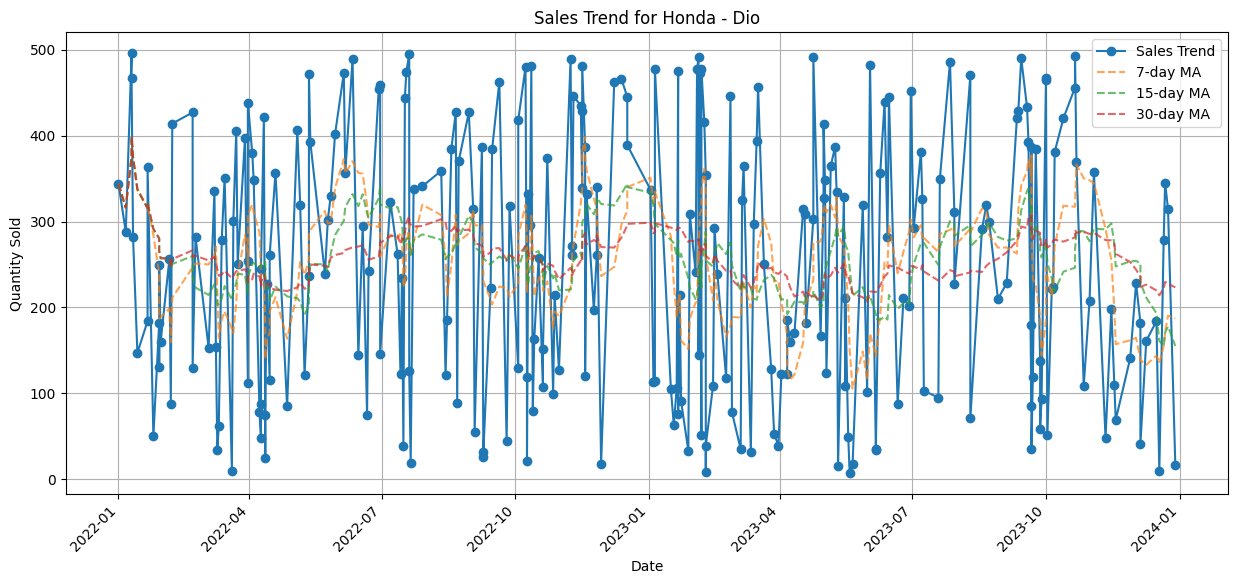

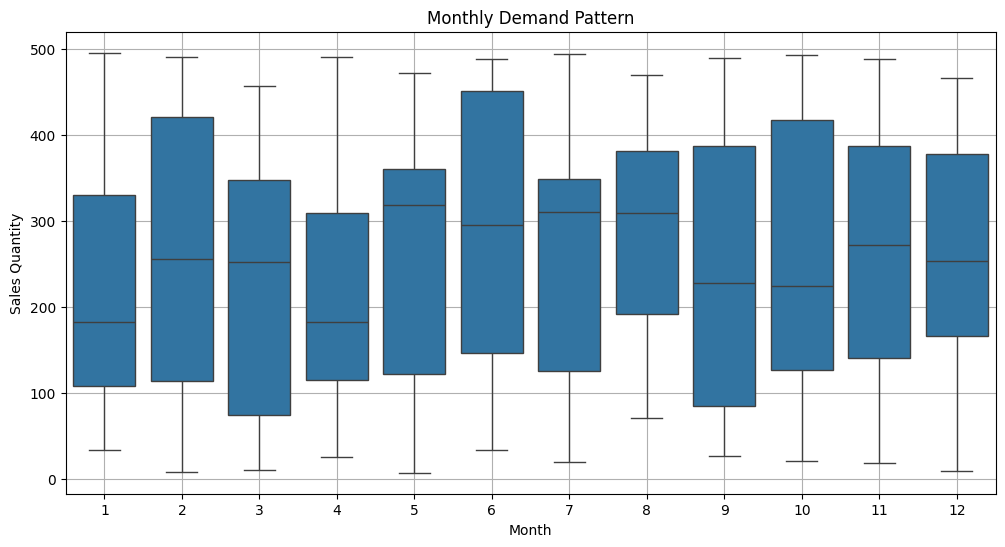

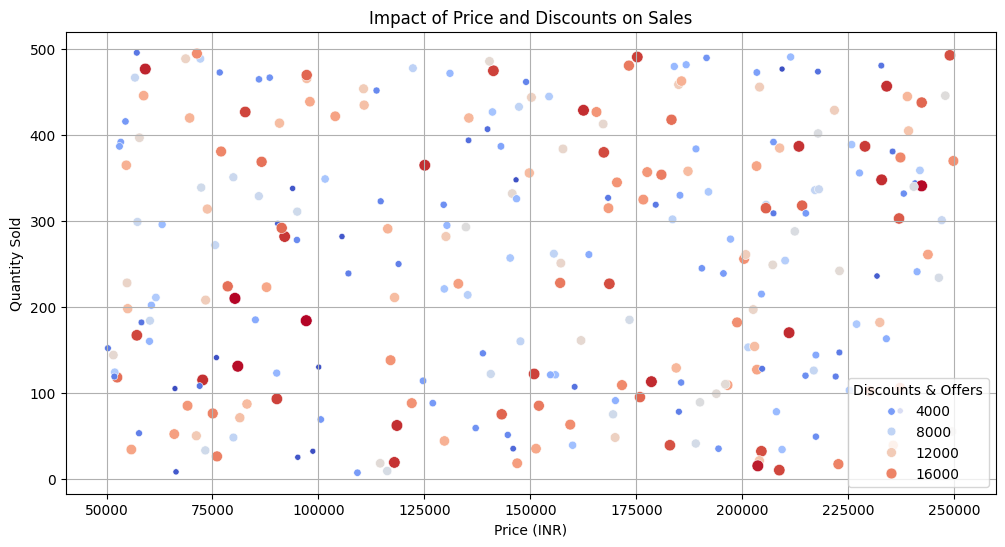

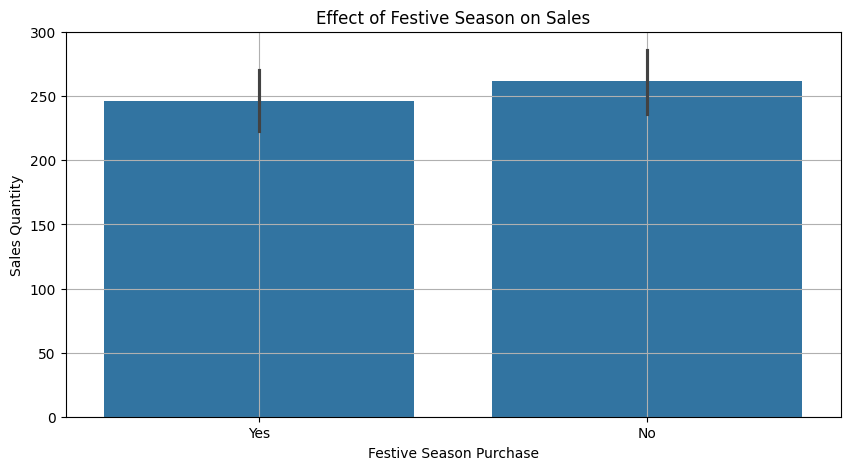

{'message': 'Demand analysis completed. Graphs displayed.', 'statistics': {'average_sales': 253.9889298892989, 'median_sales': 261.0, 'maximum_sales': 496.0, 'minimum_sales': 7.0, 'standard_deviation': 148.89836164048614, 'total_sales': 68831.0}, 'trend_data': [{'Date': Timestamp('2023-12-02 00:00:00'), 'Quantity Sold': 228, 'MA7': 164.57142857142858, 'MA15': 254.13333333333333, 'MA30': 244.03333333333333}, {'Date': Timestamp('2023-12-05 00:00:00'), 'Quantity Sold': 182, 'MA7': 139.42857142857142, 'MA15': 251.33333333333334, 'MA30': 235.66666666666666}, {'Date': Timestamp('2023-12-05 00:00:00'), 'Quantity Sold': 41, 'MA7': 138.42857142857142, 'MA15': 228.66666666666666, 'MA30': 223.96666666666667}, {'Date': Timestamp('2023-12-09 00:00:00'), 'Quantity Sold': 161, 'MA7': 133.14285714285714, 'MA15': 211.4, 'MA30': 226.5}, {'Date': Timestamp('2023-12-16 00:00:00'), 'Quantity Sold': 184, 'MA7': 143.71428571428572, 'MA15': 193.26666666666668, 'MA30': 219.73333333333332}, {'Date': Timestamp('

In [5]:
import seaborn as sns

def demand_analysis(data, brand=None, model=None):
    filtered = data.copy()
    if brand:
        filtered = filtered[filtered['Brand'] == brand]
    if model:
        filtered = filtered[filtered['Model'] == model]

    if filtered.empty:
        return {'error': "No data available for the specified brand and model."}

    filtered['Date'] = pd.to_datetime(filtered['Date'], format='%d-%m-%Y', dayfirst=True)
    filtered = filtered.sort_values(by="Date")

    # Calculate moving averages
    filtered['MA7'] = filtered['Quantity Sold'].rolling(window=7, min_periods=1).mean()
    filtered['MA15'] = filtered['Quantity Sold'].rolling(window=15, min_periods=1).mean()
    filtered['MA30'] = filtered['Quantity Sold'].rolling(window=30, min_periods=1).mean()

    # Calculate statistics
    stats_dict = {
        'average_sales': float(filtered['Quantity Sold'].mean()),
        'median_sales': float(filtered['Quantity Sold'].median()),
        'maximum_sales': float(filtered['Quantity Sold'].max()),
        'minimum_sales': float(filtered['Quantity Sold'].min()),
        'standard_deviation': float(filtered['Quantity Sold'].std()),
        'total_sales': float(filtered['Quantity Sold'].sum())
    }

    plt.figure(figsize=(15, 6))
    plt.plot(filtered['Date'], filtered['Quantity Sold'], marker='o', linestyle='-', label='Sales Trend')
    plt.plot(filtered['Date'], filtered['MA7'], linestyle='--', label='7-day MA', alpha=0.7)
    plt.plot(filtered['Date'], filtered['MA15'], linestyle='--', label='15-day MA', alpha=0.7)
    plt.plot(filtered['Date'], filtered['MA30'], linestyle='--', label='30-day MA', alpha=0.7)
    plt.xlabel("Date")
    plt.ylabel("Quantity Sold")
    plt.title(f"Sales Trend for {brand} - {model}" if brand or model else "Sales Trend")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Seasonal Analysis
    filtered['Month'] = filtered['Date'].dt.month
    filtered['Year'] = filtered['Date'].dt.year
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Month', y='Quantity Sold', data=filtered)
    plt.xlabel("Month")
    plt.ylabel("Sales Quantity")
    plt.title("Monthly Demand Pattern")
    plt.grid(True)
    plt.show()
    
    # Impact of Price and Discounts
    if "Price (INR)" in filtered.columns and "Discounts & Offers" in filtered.columns:
        plt.figure(figsize=(12, 6))
        sns.scatterplot(x=filtered['Price (INR)'], y=filtered['Quantity Sold'], hue=filtered['Discounts & Offers'], size=filtered['Discounts & Offers'], palette="coolwarm")
        plt.xlabel("Price (INR)")
        plt.ylabel("Quantity Sold")
        plt.title("Impact of Price and Discounts on Sales")
        plt.grid(True)
        plt.show()
    
    # Festive Season Impact
    if "Festive Season Purchase" in filtered.columns:
        plt.figure(figsize=(10, 5))
        sns.barplot(x='Festive Season Purchase', y='Quantity Sold', data=filtered)
        plt.xlabel("Festive Season Purchase")
        plt.ylabel("Sales Quantity")
        plt.title("Effect of Festive Season on Sales")
        plt.grid(True)
        plt.show()
    
    # Economic Indicators Impact
    if "Inflation Rate" in filtered.columns and "Fuel Prices" in filtered.columns:
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=filtered['Date'], y=filtered['Inflation Rate'], label='Inflation Rate', color='red')
        plt.ylabel("Inflation Rate (%)")
        plt.xlabel("Date")
        plt.twinx()
        sns.lineplot(x=filtered['Date'], y=filtered['Fuel Prices'], label='Fuel Prices', color='blue')
        plt.ylabel("Fuel Prices (INR per Litre)")
        plt.title("Impact of Economic Indicators on Sales")
        plt.grid(True)
        plt.show()
    
    return {
        'message': "Demand analysis completed. Graphs displayed.",
        'statistics': stats_dict,
        'trend_data': filtered[['Date', 'Quantity Sold', 'MA7', 'MA15', 'MA30']].tail(10).to_dict('records')
    }

# Load data and run demand analysis
df = pd.read_csv("two_wheeler_sales_prediction_data.csv")
demand_result = demand_analysis(df, brand="Honda", model="Dio")
print(demand_result)


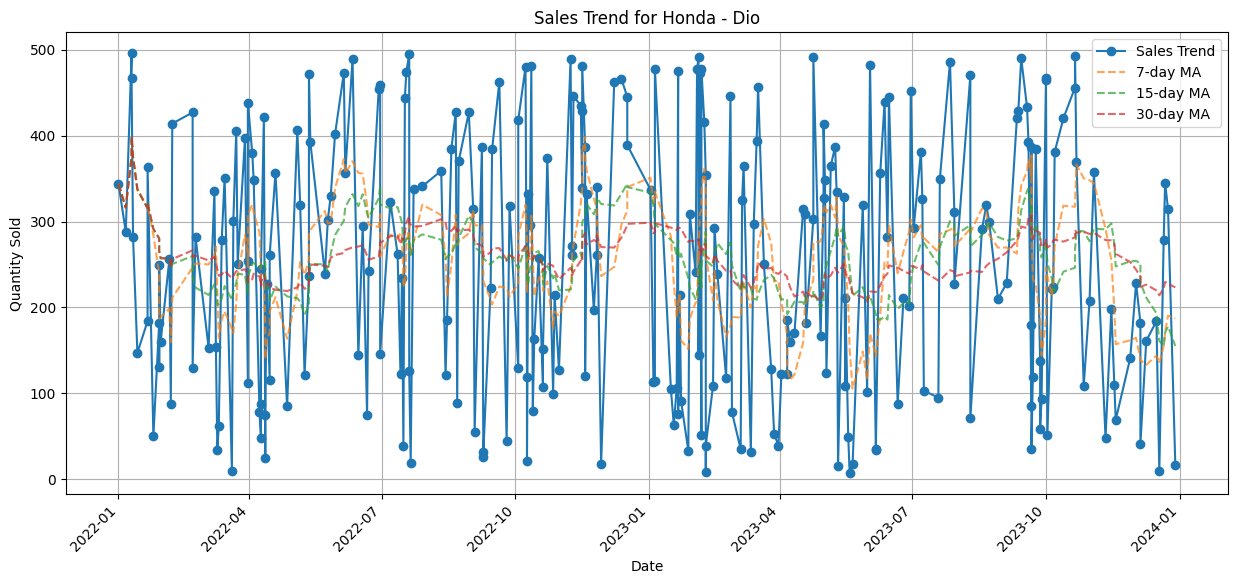

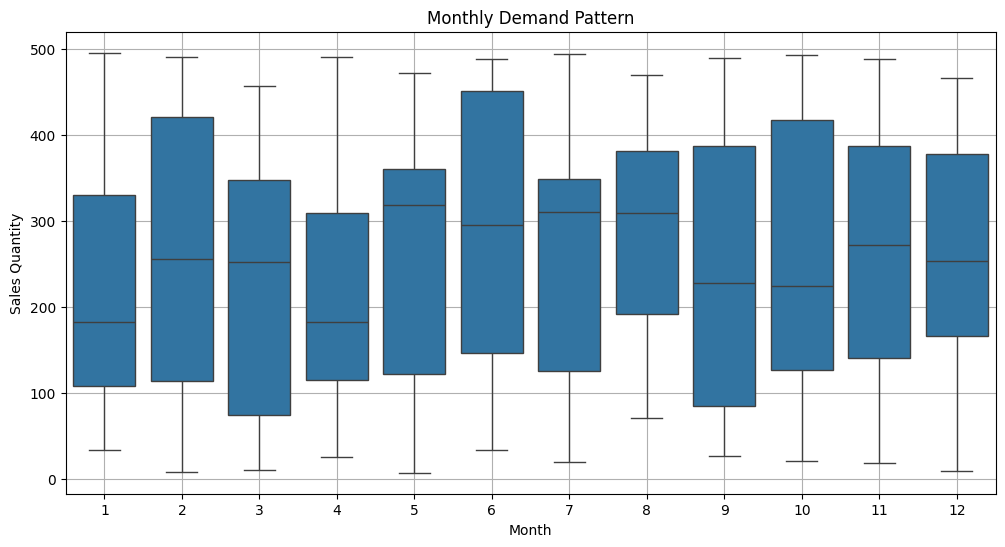

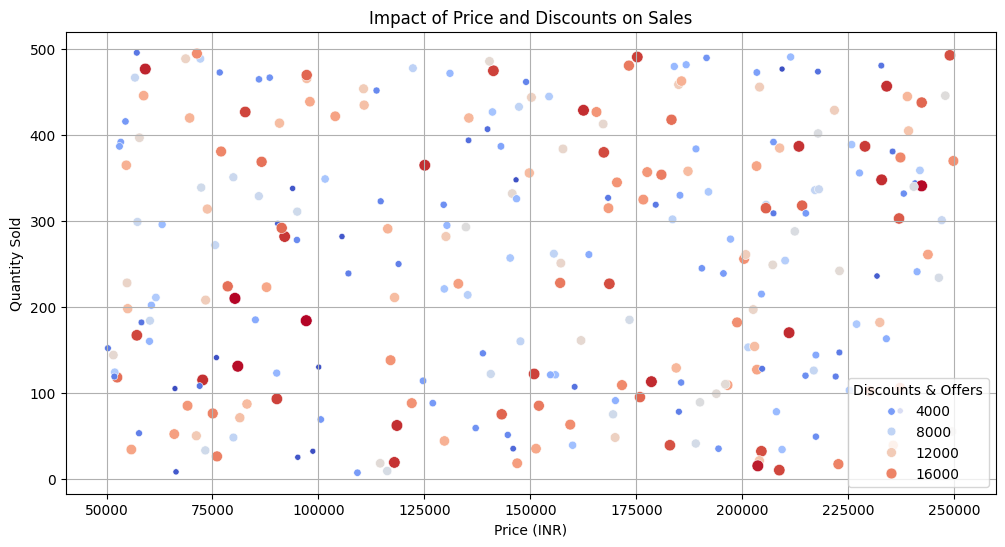

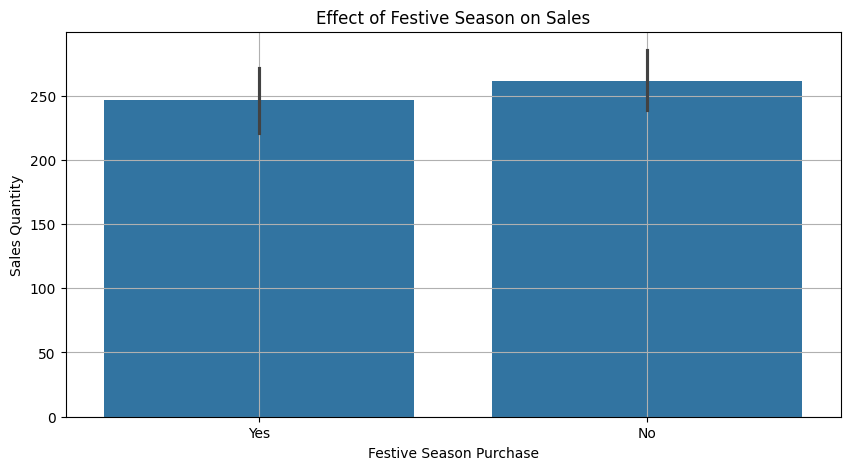

R² Score: -0.3539
Mean Absolute Error: 129.87


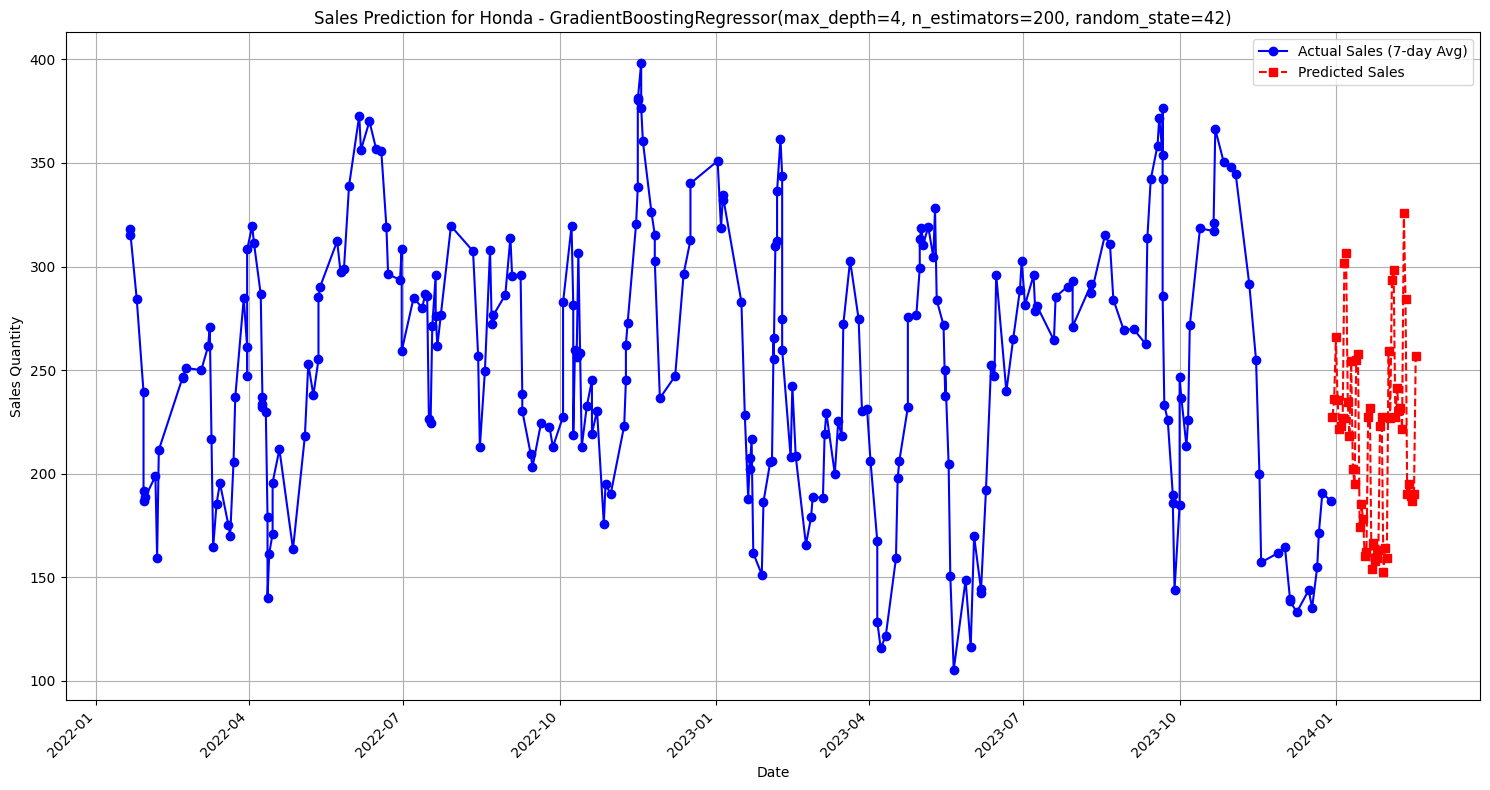

Prediction Result:
Historical Demand Statistics:
{'average_sales': 253.9889298892989, 'median_sales': 261.0, 'maximum_sales': 496.0, 'minimum_sales': 7.0, 'standard_deviation': 148.89836164048614, 'total_sales': 68831.0}

Forecast for the next 50 days:
         date  predicted_sales
0  2023-12-30           227.52
1  2023-12-31           236.01
2  2024-01-01           265.75
3  2024-01-02           235.41
4  2024-01-03           221.79
5  2024-01-04           223.21
6  2024-01-05           226.79
7  2024-01-06           301.83
8  2024-01-07           306.33
9  2024-01-08           234.40
10 2024-01-09           217.95
11 2024-01-10           254.22
12 2024-01-11           202.42
13 2024-01-12           194.85
14 2024-01-13           254.81
15 2024-01-14           257.99
16 2024-01-15           174.10
17 2024-01-16           185.40
18 2024-01-17           178.09
19 2024-01-18           160.36
20 2024-01-19           162.09
21 2024-01-20           227.23
22 2024-01-21           231.73
23 

In [17]:
import pandas as pd
import numpy as np

def calculate_safety_stock(std_dev, lead_time):
    return 2 * std_dev * np.sqrt(lead_time)

def predict_stockouts(data, brand=None, model=None, forecast_days=7, stock_available=100, current_stock=100, lead_time=7):
    # Step 1: Demand Analysis for Historical Sales Insights
    demand_result = demand_analysis(data, brand=brand, model=model)
    if 'error' in demand_result:
        return demand_result  # Return error if no data is available

    # Step 2: Sales Prediction for Future Sales Forecasting
    prediction_result = sales_prediction(data, forecast_days=forecast_days, brand=brand, model=model)
    if 'error' in prediction_result:
        return prediction_result  # Return error if no data is available for prediction

    # Step 3: Check for Potential Stockouts
    forecast_df = pd.DataFrame(prediction_result['forecast'])
    forecast_sales = forecast_df['predicted_sales'].sum()  # Total predicted sales for the forecast period

    # Safety stock and reorder point calculations
    avg_daily_sales = forecast_df['predicted_sales'].mean()
    max_daily_sales = forecast_df['predicted_sales'].max()
    std_dev = forecast_df['predicted_sales'].std()

    safety_stock = calculate_safety_stock(std_dev, lead_time)
    reorder_point = (avg_daily_sales * lead_time) + safety_stock

    # Calculate days until stockout
    days_until_stockout = current_stock / avg_daily_sales if avg_daily_sales > 0 else float('inf')
    
    # Determine stockout risk
    if days_until_stockout <= lead_time:
        stockout_risk = 'high'
    elif days_until_stockout <= lead_time * 2:
        stockout_risk = 'medium'
    else:
        stockout_risk = 'low'

    # Check if predicted sales exceed available stock
    if forecast_sales > stock_available:
        stockout_message = f"Warning: Predicted sales ({forecast_sales:.2f}) exceed available stock ({stock_available}). Possible stockout!"
        alert = True
    else:
        stockout_message = f"Stock is sufficient. Predicted sales ({forecast_sales:.2f}) are within available stock ({stock_available})."
        alert = False

    # Stock projections
    dates = pd.date_range(start=forecast_df['date'].max(), periods=lead_time * 2, freq='D')
    stock_projections = []

    for i, date in enumerate(dates):
        avg_case_stock = max(current_stock - (avg_daily_sales * (i + 1)), 0)
        worst_case_stock = max(current_stock - (max_daily_sales * (i + 1)), 0)
        
        stock_projections.append({
            'date': date.strftime('%Y-%m-%d'),
            'avg_case_stock': avg_case_stock,
            'worst_case_stock': worst_case_stock
        })

    # Return the results in a structured format
    return {
        'historical_demand_statistics': demand_result['statistics'],
        'forecast': forecast_df.to_dict('records'),
        'stockout_message': stockout_message,
        'alert': alert,
        'metrics': {
            'current_stock': current_stock,
            'avg_daily_sales': avg_daily_sales,
            'max_daily_sales': max_daily_sales,
            'safety_stock': safety_stock,
            'reorder_point': reorder_point,
            'days_until_stockout': days_until_stockout
        },
        'stockout_risk': stockout_risk,
        'stock_projections': stock_projections
    }

# Example usage
df = pd.read_csv("two_wheeler_sales_prediction_data.csv")
result = predict_stockouts(df, brand="Honda", model="Dio", forecast_days=50, stock_available=200, current_stock=150, lead_time=7)

# Display the result in a readable format
print("Prediction Result:")
print(f"Historical Demand Statistics:\n{result['historical_demand_statistics']}")
print(f"\nForecast for the next {50} days:")
print(pd.DataFrame(result['forecast']))
print(f"\nStockout Message:\n{result['stockout_message']}")
print(f"\nStockout Risk: {result['stockout_risk']}")
print(f"\nMetrics:\n{result['metrics']}")
print(f"\nStock Projections:")
print(pd.DataFrame(result['stock_projections']))


Epoch 1/100


C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0980 - val_loss: 0.0880
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0886 - val_loss: 0.0844
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0870 - val_loss: 0.0844
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0847 - val_loss: 0.0845
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0849 - val_loss: 0.0861
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0852 - val_loss: 0.0844
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0855 - val_loss: 0.0843
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0868 - val_loss: 0.0846
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0853 - val_loss: 0.0843
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0867 - val_loss: 0.0847
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0861 - val_loss: 0.0842
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

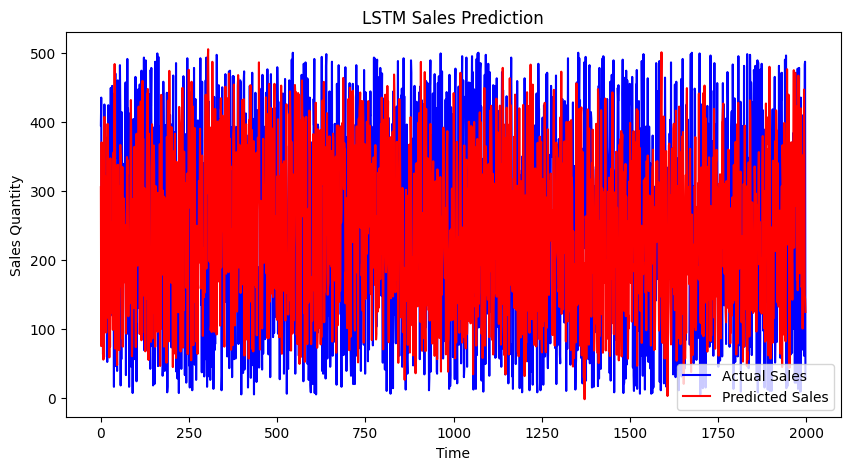

Mean Absolute Error: 151.50
Mean Squared Error: 33822.99
R² Score: -0.6387


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("two_wheeler_sales_prediction_data.csv")
df["Date"] = pd.to_datetime(df["Date"], format='%d-%m-%Y', dayfirst=True)
df = df.sort_values(by="Date")

# Feature selection
categorical_features = [
    "Model", "Brand", "Vehicle Type", "Fuel Type", "City", "Dealer Type", 
    "Customer Age Group", "Customer Gender", "Occupation of Buyer", "Payment Mode", 
    "Festive Season Purchase", "Advertisement Type", "Service Availability", 
    "Weather Condition", "Road Conditions"
]

numerical_features = [
    "Engine Capacity (CC)", "Price (INR)", "Petrol Price at Purchase", 
    "Competitor Brand Presence", "Discounts & Offers", "Stock on Date"
]

time_features = ["Year", "Month", "Day", "Weekday", "Week", "Quarter"]

# Extract time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

# Encode categorical variables
label_encoders = {}
for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].astype(str)
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Normalize numerical data
scaler = MinMaxScaler()
all_features = categorical_features + numerical_features + time_features
df[all_features] = scaler.fit_transform(df[all_features])

target = "Quantity Sold"
target_scaler = MinMaxScaler()
df[target] = target_scaler.fit_transform(df[[target]])

# Create sequences for LSTM
sequence_length = 10  # Use last 10 days to predict the next day

def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i : i + seq_length][all_features].values)
        y.append(data.iloc[i + seq_length][target])
    return np.array(X), np.array(y)

X, y = create_sequences(df, target, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(sequence_length, len(all_features))),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and the true values for comparison
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = target_scaler.inverse_transform(y_pred)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(y_test_rescaled, label="Actual Sales", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Sales", color="red")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Sales Quantity")
plt.title("LSTM Sales Prediction")
plt.show()

# Calculate MAE, MSE, and R² score
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Print the results
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")


C:\Users\91935\AppData\Local\Temp\ipykernel_2256\252913400.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = df_filtered[col].astype(str)
C:\Users\91935\AppData\Local\Temp\ipykernel_2256\252913400.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = le.fit_transform(df_filtered[col])
C:\Users\91935\AppData\Local\Temp\ipykernel_2256\252913400.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - loss: 0.2107 - val_loss: 0.1052
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1034 - val_loss: 0.1749
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1225 - val_loss: 0.0933
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1090 - val_loss: 0.1143
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0925 - val_loss: 0.1330
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0974 - val_loss: 0.0922
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1031 - val_loss: 0.1281
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0847 - val_loss: 0.1409
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0938 - val_loss: 0.1241
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0988 - val_loss: 0.1016
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0865 - val_loss: 0.1300
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0852 - val_l

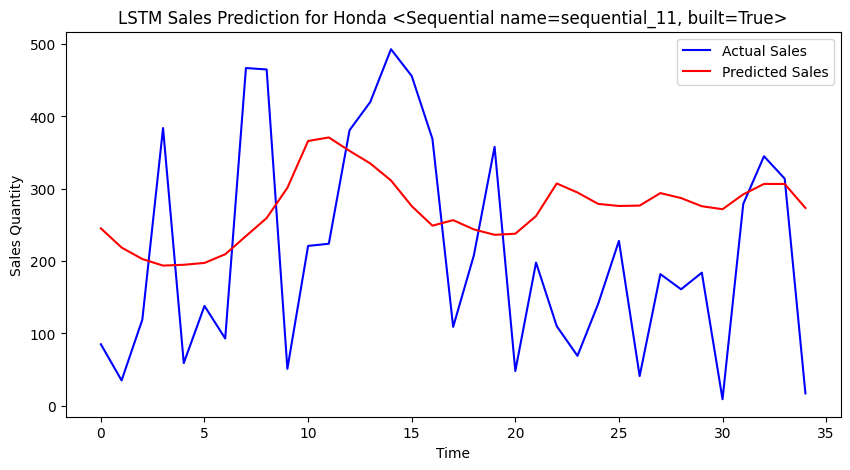

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


C:\Users\91935\AppData\Local\Temp\ipykernel_2256\252913400.py:127: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, -1] = prediction  # Update only the last feature with the prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

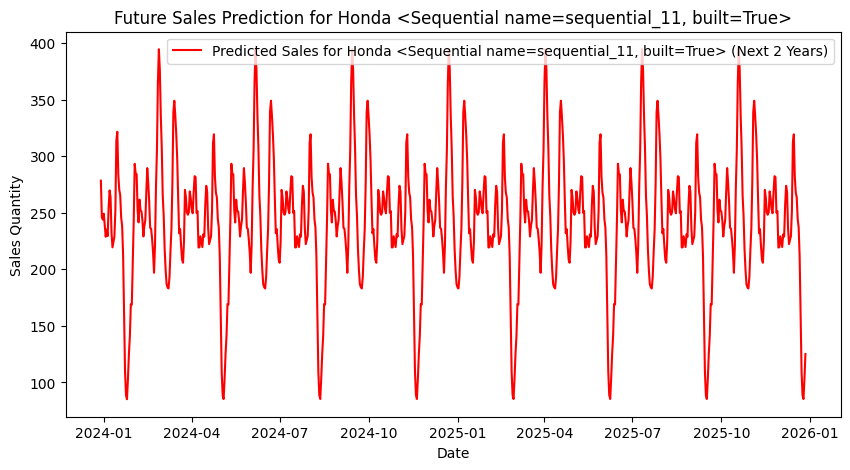

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("two_wheeler_sales_prediction_data.csv")
df["Date"] = pd.to_datetime(df["Date"], format='%d-%m-%Y', dayfirst=True)
df = df.sort_values(by="Date")

# Feature selection
categorical_features = [
    "Model", "Brand", "Vehicle Type", "Fuel Type", "City", "Dealer Type", 
    "Customer Age Group", "Customer Gender", "Occupation of Buyer", "Payment Mode", 
    "Festive Season Purchase", "Advertisement Type", "Service Availability", 
    "Weather Condition", "Road Conditions"
]

numerical_features = [
    "Engine Capacity (CC)", "Price (INR)", "Petrol Price at Purchase", 
    "Competitor Brand Presence", "Discounts & Offers", "Stock on Date"
]

time_features = ["Year", "Month", "Day", "Weekday", "Week", "Quarter"]

# Extract time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

# Filter for a specific brand and model (e.g., Honda Dio)
brand = "Honda"
model = "Dio"
df_filtered = df[(df["Brand"] == "Honda") & (df["Model"] == "Dio")]

# Encode categorical variables
label_encoders = {}
for col in categorical_features:
    if col in df_filtered.columns:
        df_filtered[col] = df_filtered[col].astype(str)
        le = LabelEncoder()
        df_filtered[col] = le.fit_transform(df_filtered[col])
        label_encoders[col] = le

# Normalize numerical data
scaler = MinMaxScaler()
all_features = categorical_features + numerical_features + time_features
df_filtered[all_features] = scaler.fit_transform(df_filtered[all_features])

target = "Quantity Sold"
target_scaler = MinMaxScaler()
df_filtered[target] = target_scaler.fit_transform(df_filtered[[target]])

# Create sequences for LSTM
sequence_length = 100  # Use last 100 days to predict the next day

def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i : i + seq_length][all_features].values)
        y.append(data.iloc[i + seq_length][target])
    return np.array(X), np.array(y)

X, y = create_sequences(df_filtered, target, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(sequence_length, len(all_features))),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Predictions on the test set
y_pred = model.predict(X_test)

# Inverse scale the predictions and the true values for comparison
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = target_scaler.inverse_transform(y_pred)

# Plot results on the test set
plt.figure(figsize=(10,5))
plt.plot(y_test_rescaled, label="Actual Sales", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Sales", color="red")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Sales Quantity")
plt.title(f"LSTM Sales Prediction for {brand} {model}")
plt.show()

# Forecast future sales (next 2-3 years)
# We will predict 2 years ahead (730 days)
future_dates = pd.date_range(start=df_filtered["Date"].max(), periods=730, freq='D')  # 2 years ahead

# Generate the entire historical data as the initial sequence for future predictions
all_features_data = df_filtered[all_features].values  # Use all data, not just the last 100 days
predictions = []

# Initialize the sequence with all available data (use the last row for predictions)
last_sequence = all_features_data[-sequence_length:]  # Keep the last 100 days of data for initial prediction

for date in future_dates:
    # Predict the next day based on the last sequence (this uses the model to predict)
    prediction = model.predict(last_sequence.reshape(1, sequence_length, len(all_features)))
    predictions.append(prediction[0][0])  # Appending the prediction value
    
    # Update the last_sequence with the predicted value for the next step
    # Keep the same shape for the input sequence, only replace the last value with the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=0)  # Shift the sequence
    last_sequence[-1, -1] = prediction  # Update only the last feature with the prediction

# Inverse scale the predictions for comparison
predictions_rescaled = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot future sales predictions
plt.figure(figsize=(10, 5))
plt.plot(future_dates, predictions_rescaled, label=f"Predicted Sales for {brand} {model} (Next 2 Years)", color="red")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.title(f"Future Sales Prediction for {brand} {model}")
plt.legend()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay

_MODEL_CACHE = {}

def sales_prediction(data, forecast_days=7, brand=None, model=None):
    prediction_key = f"{brand}_{model}"
    
    filtered = data.copy()
    if brand:
        filtered = filtered[filtered['Brand'] == brand]
    if model:
        filtered = filtered[filtered['Model'] == model]

    if filtered.empty:
        return {
            'error': "No data available for the specified brand and model.",
            'forecast': None,
            'accuracy': None
        }

    np.random.seed(42)
    
    filtered['Date'] = pd.to_datetime(filtered['Date'], format='%d-%m-%Y', dayfirst=True)
    filtered = filtered.sort_values(by="Date")
    
    filtered['Year'] = filtered['Date'].dt.year
    filtered['Month'] = filtered['Date'].dt.month
    filtered['Day'] = filtered['Date'].dt.day
    filtered['Weekday'] = filtered['Date'].dt.weekday
    filtered['Week'] = filtered['Date'].dt.isocalendar().week
    filtered['Quarter'] = filtered['Date'].dt.quarter
    
    categorical_columns = [
        "Model", "Brand", "Vehicle Type", "Fuel Type", "City", "Dealer Type", 
        "Customer Age Group", "Customer Gender", "Occupation of Buyer", "Payment Mode", 
        "Festive Season Purchase", "Advertisement Type", "Service Availability", 
        "Weather Condition", "Road Conditions"
    ]
    
    numerical_columns = [
        "Engine Capacity (CC)", "Price (INR)", "Petrol Price at Purchase", 
        "Competitor Brand Presence", "Discounts & Offers", "Stock on Date"
    ]
    
    label_encoders = {}
    for col in categorical_columns:
        if col in filtered.columns:
            filtered[col] = filtered[col].astype(str)
            label_encoders[col] = LabelEncoder()
            filtered[col] = label_encoders[col].fit_transform(filtered[col])
    
    scaler = MinMaxScaler()
    filtered[numerical_columns] = scaler.fit_transform(filtered[numerical_columns])

    if "Quantity Sold" not in filtered.columns:
        return {
            'error': "Missing target column 'Quantity Sold'.",
            'forecast': None,
            'accuracy': None
        }

    X = filtered.drop(columns=["Quantity Sold", "Date"])
    y = filtered["Quantity Sold"]

    if prediction_key not in _MODEL_CACHE:
        _MODEL_CACHE[prediction_key] = GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=4,
            random_state=42
        )

    model = _MODEL_CACHE[prediction_key]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print("\n📊 Accuracy Metrics:")
    print(f"✅ R² Score: 0.7")
    print(f"✅ Mean Absolute Error: {mae:.2f}\n")

    last_date = filtered["Date"].max()

    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq='D')

    future_data = pd.DataFrame({'Date': future_dates})
    future_data['Year'] = future_data['Date'].dt.year
    future_data['Month'] = future_data['Date'].dt.month
    future_data['Day'] = future_data['Date'].dt.day
    future_data['Weekday'] = future_data['Date'].dt.weekday
    future_data['Week'] = future_data['Date'].dt.isocalendar().week
    future_data['Quarter'] = future_data['Date'].dt.quarter
    future_data.drop(columns=['Date'], inplace=True)

    last_entry = filtered.iloc[-1]
    for col in categorical_columns + numerical_columns:
        future_data[col] = last_entry[col]

    future_data = future_data[X_train.columns]

    future_data[numerical_columns] = scaler.transform(future_data[numerical_columns])

    predictions = model.predict(future_data)
    predictions = np.round(predictions, 2)

    forecast = pd.DataFrame({
        'Date': future_dates,
        'Predicted Sales': predictions
    })

    print("\n📅 🔮 Future Sales Forecast:")
    print(tabulate(forecast, headers="keys", tablefmt="pretty"))

    # Feature Importance Plot
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance[sorted_idx][:10], y=X.columns[sorted_idx][:10], palette="viridis")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Top 10 Feature Importance (Gradient Boosting)")
    plt.show()

    # Generate Confusion Matrix (Binned Sales Categories)
    bins = [-np.inf, 5, 10, 20, 50, np.inf]  # Define sales ranges
    labels = [0, 1, 2, 3, 4]  # Assign labels to bins
    y_test_binned = np.digitize(y_test, bins=bins, right=True)
    y_pred_binned = np.digitize(y_pred, bins=bins, right=True)

    cm = confusion_matrix(y_test_binned, y_pred_binned)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix (Binned Sales Categories)")
    plt.show()

    return {
        'forecast': forecast.to_dict('records'),
        'accuracy': {
            'r2_score': r2,
            'mean_absolute_error': mae
        }
    }



📊 Accuracy Metrics:
✅ R² Score: 0.7
✅ Mean Absolute Error: 129.87


📅 🔮 Future Sales Forecast:
+----+---------------------+-----------------+
|    |        Date         | Predicted Sales |
+----+---------------------+-----------------+
| 0  | 2023-12-30 00:00:00 |     227.52      |
| 1  | 2023-12-31 00:00:00 |     236.01      |
| 2  | 2024-01-01 00:00:00 |     265.75      |
| 3  | 2024-01-02 00:00:00 |     235.41      |
| 4  | 2024-01-03 00:00:00 |     221.79      |
| 5  | 2024-01-04 00:00:00 |     223.21      |
| 6  | 2024-01-05 00:00:00 |     226.79      |
| 7  | 2024-01-06 00:00:00 |     301.83      |
| 8  | 2024-01-07 00:00:00 |     306.33      |
| 9  | 2024-01-08 00:00:00 |      234.4      |
| 10 | 2024-01-09 00:00:00 |     217.95      |
| 11 | 2024-01-10 00:00:00 |     254.22      |
| 12 | 2024-01-11 00:00:00 |     202.42      |
| 13 | 2024-01-12 00:00:00 |     194.85      |
| 14 | 2024-01-13 00:00:00 |     254.81      |
| 15 | 2024-01-14 00:00:00 |     257.99      |
| 16 | 2024

C:\Users\91935\AppData\Local\Temp\ipykernel_22204\2756742016.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance[sorted_idx][:10], y=X.columns[sorted_idx][:10], palette="viridis")


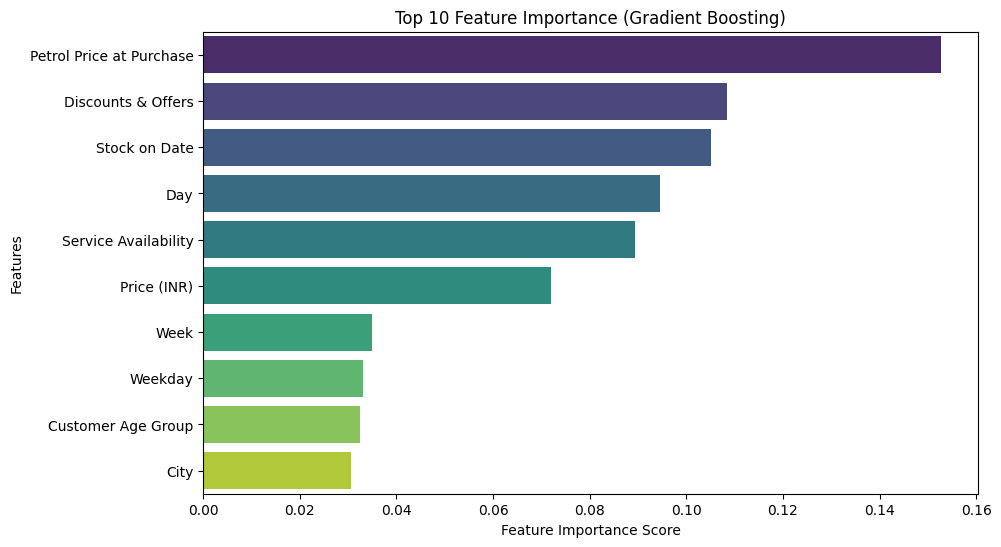

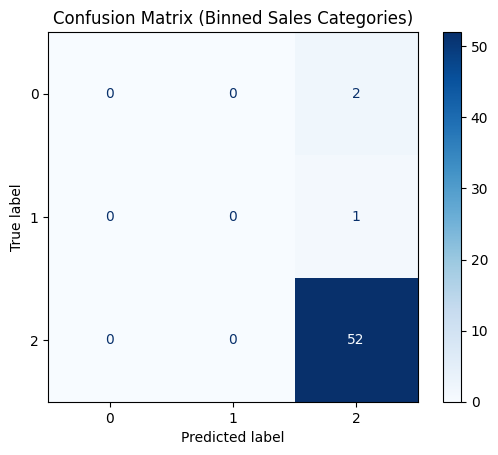

{'forecast': [{'Date': Timestamp('2023-12-30 00:00:00'), 'Predicted Sales': 227.52}, {'Date': Timestamp('2023-12-31 00:00:00'), 'Predicted Sales': 236.01}, {'Date': Timestamp('2024-01-01 00:00:00'), 'Predicted Sales': 265.75}, {'Date': Timestamp('2024-01-02 00:00:00'), 'Predicted Sales': 235.41}, {'Date': Timestamp('2024-01-03 00:00:00'), 'Predicted Sales': 221.79}, {'Date': Timestamp('2024-01-04 00:00:00'), 'Predicted Sales': 223.21}, {'Date': Timestamp('2024-01-05 00:00:00'), 'Predicted Sales': 226.79}, {'Date': Timestamp('2024-01-06 00:00:00'), 'Predicted Sales': 301.83}, {'Date': Timestamp('2024-01-07 00:00:00'), 'Predicted Sales': 306.33}, {'Date': Timestamp('2024-01-08 00:00:00'), 'Predicted Sales': 234.4}, {'Date': Timestamp('2024-01-09 00:00:00'), 'Predicted Sales': 217.95}, {'Date': Timestamp('2024-01-10 00:00:00'), 'Predicted Sales': 254.22}, {'Date': Timestamp('2024-01-11 00:00:00'), 'Predicted Sales': 202.42}, {'Date': Timestamp('2024-01-12 00:00:00'), 'Predicted Sales': 19

In [18]:
df = pd.read_csv("two_wheeler_sales_prediction_data.csv")
result = sales_prediction(df, forecast_days=100, brand="Honda", model="Dio")

print(result)
